In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import imageio
import fiona
import rioxarray as rxr
import matplotlib.pyplot as plt
from osgeo import gdal

from dem_utils_import import load_rast, gdal_process, load_json, plot_rast
import validate_results

C:\Users\montse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
file_path = '../inputs/sru_data/sru_saetde.json'
file_to_test = load_json.load_json_file(file_path)
features = [feature['geometry'] for feature in file_to_test]

#Create a gdf to compare the data
file_gdf = gpd.GeoDataFrame(file_to_test)

#unpack_dict = file_gdf['properties'].apply(pd.Series)
areas_gdf = pd.concat([file_gdf, file_gdf['properties'].apply(pd.Series)], axis=1)
areas_gdf.drop(columns= ['type', 'properties', 'id', 'alt_avg', 'alt_min', 'alt_max', 'snowtype', 'configuration_id'], inplace=True)
areas_gdf['null'] = ''; areas_gdf['properties_kram'] = ''

areas_gdf

,geometry,alt,slope_avg,aspect_avg,slope,aspect,area,null,properties_kram
0,"{'type': 'MultiPolygon', 'coordinates': [[[[1....",2400,11.507121,241.895492,20,225,6967.42,,
1,"{'type': 'MultiPolygon', 'coordinates': [[[[1....",2400,14.240822,217.603011,20,225,9936.70,,
2,"{'type': 'MultiPolygon', 'coordinates': [[[[1....",2400,15.360473,234.188249,20,225,7466.11,,
3,"{'type': 'MultiPolygon', 'coordinates': [[[[1....",2400,10.166618,191.478609,20,180,1623.27,,
4,"{'type': 'MultiPolygon', 'coordinates': [[[[1....",2400,10.467845,141.264385,20,135,81654.25,,
...,...,...,...,...,...,...,...,...,...
82,"{'type': 'MultiPolygon', 'coordinates': [[[[1....",2100,9.638921,82.413484,0,-1,4551.00,,
83,"{'type': 'MultiPolygon', 'coordinates': [[[[1....",2100,15.499603,247.255007,20,225,36.47,,
84,"{'type': 'MultiPolygon', 'coordinates': [[[[1....",2400,10.914265,154.992152,20,135,17038.40,,
85,"{'type': 'MultiPolygon', 'coordinates': [[[[1....",2100,19.749536,294.350110,20,315,12088.58,,


In [3]:
dem_path = '../outputs/rasters/cropped_dem.tif'
out_tif_path = '../outputs/check_sru/saetde_sru2.tif'
out_tif_path_imageio = '../outputs/check_sru/saetde_sru_imageio.tif'
out_slope_path = '../outputs/check_sru/slope_sru_saetde.tif'
out_aspect_path = '../outputs/check_sru/aspect_sru_saetde.tif'

In [ ]:
index = 0

for geometry in enumerate(features):
  check_processus([geometry[1]], dem_path, out_tif_path, out_tif_path_imageio, out_slope_path, out_aspect_path)
  stats = get_properties(out_tif_path, out_slope_path, out_aspect_path)
  areas_gdf['properties_kram'].iloc[geometry[1]] = stats
  print(index)
  index += 1

In [4]:
validate_results.check_processus([features[1]], dem_path, out_tif_path, out_tif_path_imageio, out_slope_path, out_aspect_path)
#stats = get_properties(out_tif_path, out_slope_path, out_aspect_path)

In [6]:
output_path = './test.tif'
tif_file = load_rast.open_raster_array(out_tif_path)
load_rast.write_raster_array(tif_file, dem_path, output_path)

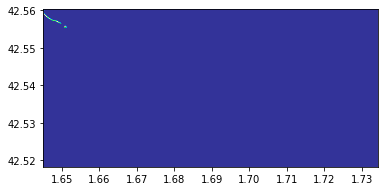

In [7]:
plot_rast.quick_show_rasterio(output_path)

In [ ]:
dem_studied = rasterio.open(out_tif_path).read()
dem_final = np.where(dem_studied > 3.3999e38, 0., dem_studied)
#dem_final = np.where(dem_studied == 0., np.nan, dem_final)
dem_final = dem_final[0, :, :]
load_rast.write_raster_array(dem_final, dem_path, out_tif_path)

In [ ]:
dem_study = rxr.open_rasterio(out_tif_path)
dem_study

In [ ]:
dem = rxr.open_rasterio(dem_path)
dem

In [ ]:
original_tif = gdal.Open(dem_path)
output_path = './test.tif'
nb_raster_band = 1
raster_array = gdal.Open(out_tif_path).GetRasterBand(1).ReadAsArray()

rows = original_tif.RasterYSize
cols = original_tif.RasterXSize
driver = gdal.GetDriverByName('GTiff')
out_dataset = driver.Create(output_path, cols, rows, 1, gdal.GDT_Float32)
geotrans = original_tif.GetGeoTransform()
projection = original_tif.GetProjection()
out_dataset.SetGeoTransform(geotrans)
out_dataset.SetProjection(projection)
out_dataset.GetRasterBand(nb_raster_band).WriteArray(raster_array)

out_dataset.FlushCache()
out_dataset = None

In [ ]:
dem = rxr.open_rasterio(out_tif_path, masked=True).squeeze()
dem

In [ ]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

cropped_dem_path = '../outputs/rasters/cropped_dem.tif'
out_tif_wgs84 = '../outputs/check_sru/saetde_sru_wgs.tif'
dst_crs = 'EPSG:4326'

with rasterio.open(out_tif_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(out_tif_wgs84, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [ ]:
trails_path = '../outputs/geojson/trails_2d.shp'
rast = rasterio.open(out_tif_path)
dem = rasterio.open(dem_path)

#crop_dem = rasterio.open(cropped_dem_path).read()
#crop_dem = np.where(crop_dem > 3.3999e38, 0., crop_dem)
trails = gpd.read_file(trails_path)

f, ax = plt.subplots(figsize=(15,15))
rasterio.plot.show(rast, ax=ax, cmap='magma') #with_bounds = True, ax=ax, cmap='magma')
rasterio.plot.show(dem, ax=ax, alpha=0.3)
#trails.plot(ax=ax, edgecolor = 'k')
plt.show()

In [ ]:
crop_dem.read()

- Set CRS to both files
- Reprojection
- Save the raster with the proper function